In [7]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [8]:
RUCIO_ACCOUNT="nihartma"

In [9]:
import time
import os
from pathlib import Path
import json
import gc
import pyarrow.parquet as pq
import fsspec
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import vector
from tqdm.auto import tqdm
from physlite_experiments.physlite_events import Factory
from physlite_experiments.analysis_example import get_obj_sel
from utils_new import setup_rucio_and_proxy, get_signed_url, SetupRucioAndProxyWorker
from rucio.client import Client

In [13]:
x509_path = Path("x509up")
if not x509_path.exists():
    x509_data = upload.data[-1]
    with x509_path.open("wb") as f:
        f.write(x509_data)
else:
    with x509_path.open("rb") as f:
        x509_data = f.read()

In [14]:
setup_rucio_and_proxy(x509_data, rucio_account=RUCIO_ACCOUNT)

In [15]:
rucio_client = Client(ca_cert=False)

In [16]:
files = list(rucio_client.list_files("user.nihartma", "user.nihartma.physlite_to_parquet_gcp_100p_2021-11-17_1605_output.parquet"))

/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-server-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-auth-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-server-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warni

In [17]:
# Total TiB
sum(file["bytes"] for file in files) / 1024 ** 4

63.21627996741336

In [8]:
files[0]["bytes"] / 1024 ** 3

12.639190495945513

In [18]:
url = get_signed_url(files[0]["scope"], files[0]["name"], ca_cert=False)

/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-server-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [212]:
class MonitoredFile:
    """
    Monitor accessed ranges
    """
    
    def __init__(self, f):
        self.f = f
        self.read_ranges = []
    
    def read(self, n):
        self.read_ranges.append((time.time_ns(), self.f.tell(), n))
        return self.f.read(n)
    
    def seek(self, *args):
        return self.f.seek(*args)
    
    def tell(self):
        return self.f.tell()
    
    @property
    def closed(self):
        return self.f.closed

In [138]:
with fsspec.open(url, cache_type="none") as f:
    f = MonitoredFile(f)
    print(pq.ParquetFile(f).num_row_groups)
    print(f.read_ranges)

64
[(1648212092751982527, 13571161921, 65536), (1648212092827793575, 13568046847, 3180602)]


In [139]:
def dunder_to_dot(events, collection):
    for k in events[collection].fields:
        if "__" in k:
            events[collection, k.replace("__", ".")] = events[collection, k]
    return events

In [140]:
def run_analysis(events):
    events = get_obj_sel(events)
    info = {
        collection: {
            flag : ak.count_nonzero(events[collection][flag])
            for flag in ["baseline", "passOR", "signal"]
        } for collection in ["Electrons", "Muons", "Jets"]
    }
    events["Muons", "m"] = 105.6583715 # muon mass was not stored yet
    leptons = ak.packed(
        events[
            ["Electrons", "Muons"],
            ["pt", "eta", "phi", "passOR", "signal", "baseline", "m"]
        ]
    )
    return {"info": info, "leptons": ak.to_arrow(leptons)}

In [141]:
%%time
with fsspec.open(url,
                 cache_type="none"
                ) as f:
    f = MonitoredFile(f)
    events = Factory.from_parquet(f, row_groups=0).events
    events = dunder_to_dot(events, "Muons")
    res = run_analysis(events)
    read_ranges = np.array(f.read_ranges)

/srv/conda/envs/notebook/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


CPU times: user 1.75 s, sys: 112 ms, total: 1.86 s
Wall time: 6.42 s


In [173]:
def plot_io(read_ranges):
    h, e = np.histogram(read_ranges[:, 0], weights=read_ranges[:, 2], bins=10)
    plt.stairs(h / (e[1:] - e[:-1]) * 1e9, e.astype("datetime64[ns]"))
    plt.xticks(rotation=45);
    plt.ylabel("bytes per second")

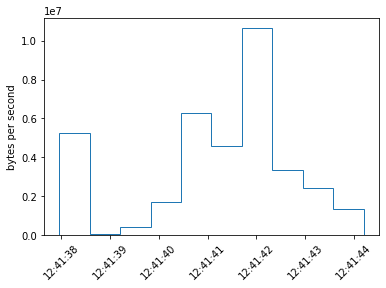

In [174]:
plot_io(read_ranges)

In [152]:
def get_num_row_groups(file):
    from utils_new import get_signed_url
    with fsspec.open(get_signed_url(file["scope"], file["name"], ca_cert=False), cache_type="none") as f:
        return pq.ParquetFile(f).num_row_groups

Start cluster with [`manage_cluster.ipynb`](manage_cluster.ipynb)

In [155]:
from dask_gateway import Gateway
gateway = Gateway()
clusters = gateway.list_clusters()
clusters

[ClusterReport<name=default.2f4428b821be4072bd8e9187e570b050, status=RUNNING>]

In [156]:
cluster = gateway.connect(clusters[0].name)
client = cluster.get_client()

In [157]:
cluster

In [160]:
from distributed.diagnostics.plugin import UploadFile
client.register_worker_plugin(UploadFile("utils_new.py"))
client.register_worker_plugin(SetupRucioAndProxyWorker(os.environ["X509_USER_PROXY"], rucio_account=RUCIO_ACCOUNT))

{'tls://10.64.1.2:40983': {'status': 'OK'},
 'tls://10.64.2.2:40393': {'status': 'OK'},
 'tls://10.64.2.3:41613': {'status': 'OK'},
 'tls://10.64.2.4:35861': {'status': 'OK'},
 'tls://10.64.2.5:36021': {'status': 'OK'},
 'tls://10.64.2.6:35521': {'status': 'OK'},
 'tls://10.64.2.7:39521': {'status': 'OK'},
 'tls://10.64.2.8:41563': {'status': 'OK'}}

In [161]:
fut = client.submit(get_num_row_groups, files[0])

In [162]:
fut.result()

64

In [163]:
if not Path("files.json").exists():
    futs = client.map(get_num_row_groups, files)
    num_row_groups = client.gather(futs)
    for file, file_rg in zip(files, num_row_groups):
        file["num_row_groups"] = file_rg
    with open("files.json", "w") as f:
        json.dump(files, f)

In [164]:
with open("files.json") as f:
    files = json.load(f)

Parallelize over files first, row groups second

In [165]:
job_params = []
for file in files:
    for i in range(file["num_row_groups"]):
        job_params.append((file, i))
job_params = sorted(job_params, key=lambda x: x[1])

In [166]:
len(job_params)

309723

In [167]:
def job_url(file):
    from utils_new import get_signed_url
    return get_signed_url(file["scope"], file["name"], ca_cert=False)

In [221]:
def job(url, row_group):
    start = time.time_ns()
    with fsspec.open(url, cache_type="none") as f:
        f = MonitoredFile(f)
        events = Factory.from_parquet(f, row_groups=row_group).events
        events = dunder_to_dot(events, "Muons")
        res = run_analysis(events)
    stop = time.time_ns()
    res["info"]["start"] = start
    res["info"]["stop"] = stop
    res["info"]["time"] = stop - start
    res["info"]["read_ranges"] = np.array(f.read_ranges)
    res["info"]["nevents"] = len(events)
    gc.collect()
    return res

In [222]:
fut_url = client.submit(job_url, files[0])
fut = client.submit(job, fut_url, 0)

In [223]:
res = fut.result()
leptons = ak.from_arrow(res["leptons"])
info = res["info"]

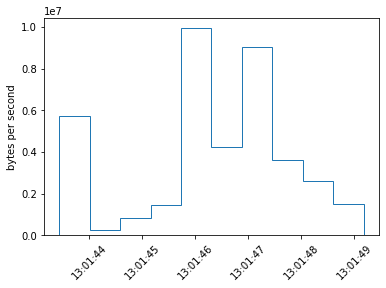

In [224]:
plot_io(info["read_ranges"])

In [225]:
info["nevents"] / info["time"]

1.1057125533832196e-05

In [208]:
leptons.Electrons.pt

<Array [[], [], [], [], ... [], [], [], []] type='65288 * option[var * float32]'>

In [302]:
futs = []
futs_url = {}
for file, row_group in job_params[:len(job_params) // 10]:
    if file["name"] not in futs_url:
        futs_url[file["name"]] = client.submit(job_url, file)
    fut_url = futs_url[file["name"]]
    futs.append(client.submit(job, fut_url, row_group))

In [309]:
read_ranges = np.concatenate(client.gather(client.map(lambda x: x["info"]["read_ranges"], futs)))

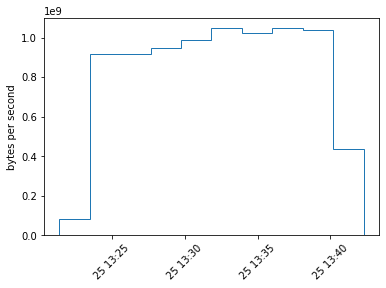

In [316]:
plot_io(read_ranges)
#plt.savefig("bytes_per_second_parquet_10p_256cores.pdf")

In [314]:
events_stat = np.array(client.gather(client.map(lambda x: (x["info"]["stop"], x["info"]["nevents"]), futs)))

Text(0, 0.5, 'Events per second')

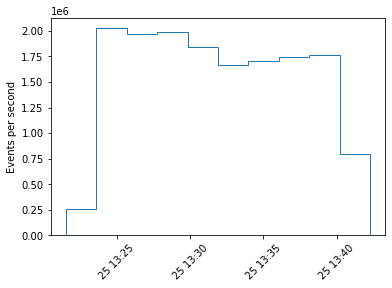

In [319]:
h, e = np.histogram(events_stat[:, 0], weights=events_stat[:, 1], bins=10)
plt.stairs(h / (e[1:] - e[:-1]) * 1e9, e.astype("datetime64[ns]"))
plt.xticks(rotation=45);
plt.ylabel("Events per second")
#plt.savefig("events_pers_second_parquet_10p_256cores.pdf")

In [320]:
def dilepton_mass(leptons):
    import vector
    vector.register_awkward()
    leptons = ak.from_arrow(leptons)
    leptons = ak.concatenate([leptons.Electrons, leptons.Muons], axis=1)
    leptons["p4"] = vector.awk(leptons[["pt", "eta", "phi", "m"]])
    lep1, lep2 = ak.unzip(ak.combinations(leptons.p4, 2))
    return ak.flatten((lep1 + lep2).m).to_numpy()

In [321]:
dilepton_mass(futs[0].result()["leptons"])

array([ 3134.70868481,  6957.97388927,  3131.97635851, ...,
         267.28614915,  3190.52976524, 90632.47675608])

In [322]:
lepton_futs = client.map(lambda res: res["leptons"], futs)

In [323]:
mass_futs = client.map(dilepton_mass, lepton_futs)

In [324]:
bins = np.geomspace(300, 150000, 500)

In [337]:
def histogram(mass):
    hist, _ = np.histogram(mass, bins=bins)
    return hist

In [338]:
mass_futs[0].result()

array([ 3134.70868481,  6957.97388927,  3131.97635851, ...,
         267.28614915,  3190.52976524, 90632.47675608])

In [339]:
#[fut for fut in futs if not fut.status == "finished"][0].retry()

In [341]:
hist = sum(client.gather(client.map(histogram, mass_futs)))

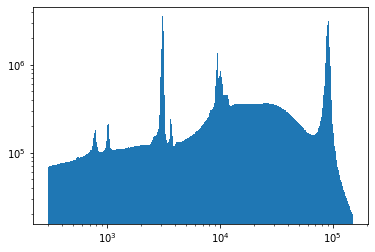

In [346]:
plt.stairs(hist, bins, fill=True)
plt.xscale("log")
plt.yscale("log")

In [348]:
cluster.shutdown()